In [1]:
import torch
import tqdm
import matplotlib.pyplot as plt
from utils import display_img, process, sample
from latent_dataset import WPlusLatentsDataset
from SAE import SparseAutoencoder
import dnnlib
import legacy
from latent_dataset import save_latents
from torch.utils.data import DataLoader
from evaluate_saes import test_reconstructions
import einops
from steering import steer_avg_activations, steer, get_top_latents

In [2]:
device = 'mps'

In [3]:
TRAIN_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_train_latents'
train_data = WPlusLatentsDataset(TRAIN_PATH)
VAL_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_val_latents'
val_data = WPlusLatentsDataset(VAL_PATH)
TEST_PATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/G_w_test_latents'
test_data = WPlusLatentsDataset(TEST_PATH)
train_loader = DataLoader(train_data, batch_size = 64, shuffle = True)
val_loader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 64, shuffle = True)

In [4]:
SAE = torch.load('/Users/spra/Desktop/Personal Projects/CV_final_project/Image-Steering-SAEs/sae1024_10epochs.pt', weights_only = False)

In [5]:
# downloaded from https://catalog.ngc.nvidia.com/orgs/nvidia/teams/research/models/stylegan2/files

FILEPATH = '/Users/spra/Desktop/Personal Projects/CV_final_project/load_pretrained_stylegan/stylegan2-celebahq-256x256.pkl'
with dnnlib.util.open_url(FILEPATH) as f:
    data = legacy.load_network_pkl(f)
    G = data["G_ema"].eval().to("mps")

Original Images:


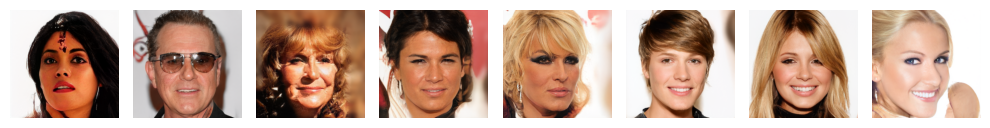

Reconstructed Images


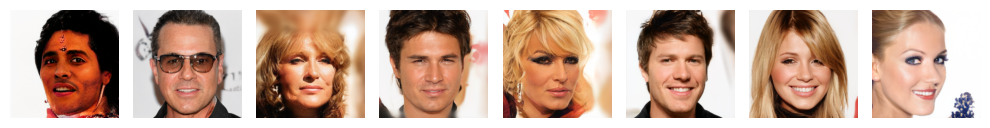

In [6]:
imgs, reconstructed_imgs = test_reconstructions(G, SAE, test_loader, h = 1, w = 8, display = True)

In [7]:
def get_avg_activations(SAE, test_loader):
    ''' 
    Gets the activations of the SAE 1024 dimensional latent averaged over a dataloader
    The mean of the resulting tensor of shape (1024, ) should be equal to the sparsity.
    '''
    avg_activations = torch.zeros((1024, )).to(device)
    total = 0
    for batch in tqdm.tqdm(test_loader):
        reconstructions, sparse_representations = SAE(batch)
        latents = sparse_representations.view(-1, 1024)
        num_latents = len(latents)
        means = latents.mean(dim = 0)
        # take weighted sum to compute mean
        avg_activations = avg_activations * total/(total + num_latents) + means * num_latents/(total + num_latents)
        total += num_latents
    return avg_activations
    

In [8]:
avg_activations = get_avg_activations(SAE, test_loader)

100%|██████████| 16/16 [00:01<00:00,  8.21it/s]


Looks like most activations are being used.

In [9]:
small = (avg_activations < 1e-4).int().sum()
small

tensor(54, device='mps:0')

In [10]:
topk, indices = torch.topk(avg_activations, k = 20)

In [11]:
topk

tensor([5.1912, 2.9630, 2.6155, 2.0779, 1.8902, 1.5763, 1.2113, 0.9930, 0.9201,
        0.9124, 0.8789, 0.8091, 0.7167, 0.7099, 0.6965, 0.6715, 0.6621, 0.6442,
        0.6114, 0.5882], device='mps:0', grad_fn=<TopkBackward0>)

In [12]:
indices

tensor([ 298,  613,  698,    2,  424,  178, 1002,  767,  891,  394,  724,  794,
         581,   54,  529,    5,  888,  833,  148,  309], device='mps:0')

For the 10 epochs SAE:

298 is gender (high is male, low is female)

613 is gender entangled with pose (high is female, low is male)

698 is gender (high is female, low is male)

2 is pose (high is facing left)

424 is pose (high is facing right)

178 is hats yay!

1002 gets more hair / voluminous + shaggy hair / hair in face

767 wider face / more masculine + hat / stuff on top of head (lots of hair)

891 idk

394 idk aaahh

724 hair getting swooped to the right

794 sunglasses

581 Darkening (background too)

54 hair swoops left

529 pose entangled with masculinity?

5 hair lightening!!!

888 black hair entangled with curliness??? black textured hair

833 bangs

148 light background

309 looking down (chin kinda tucked)



In [224]:
idx = 309

# Steering From Average Activations

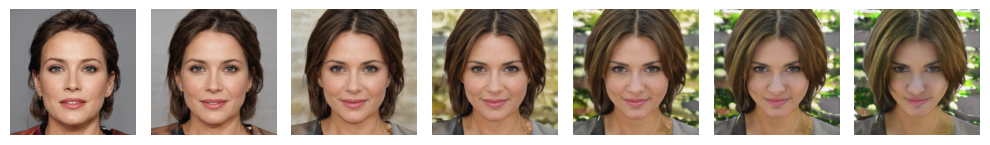

In [225]:
images = steer_avg_activations(G, SAE, avg_activations, idx, device = 'mps', min = -2, max = 10, steps = 7)
display_img(process(images), h = 1, w = 7)

# Steer Random images

In [226]:
steered_images = steer(G, SAE, test_loader, idx, num_imgs = 9, min = -2, max = 6, steps = 9)

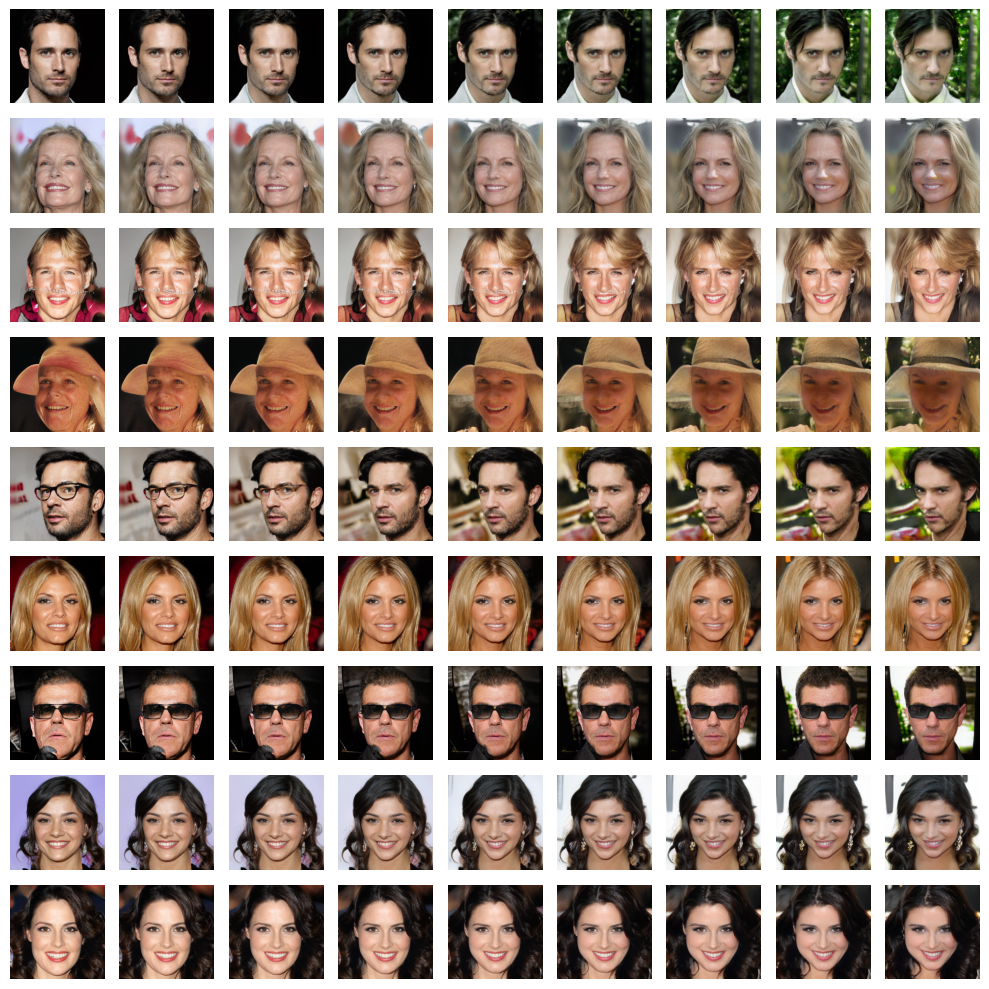

In [227]:
display_img(process(steered_images), h = 9, w = 9)

In [228]:
# for 30 epochs
# 35 seems to be an age vector
# 766 seems to be black vs light hair???
# There seem to be a lot of entangled gender ones: 895, 
# 341 seems to be something about backrounds/lighting???
# 92 seems to be hair out of face?
# 393 might be hair length?
#

# Visualize Top and Bottom Activations

100%|██████████| 1000/1000 [00:05<00:00, 189.65it/s]


tensor([8.0673, 8.0184, 7.2150, 7.0049, 6.8340, 6.8285, 6.7924, 6.6955, 6.6619,
        6.4513, 6.4428, 6.4040, 6.3687, 6.3461, 6.3388, 6.2987],
       device='mps:0')


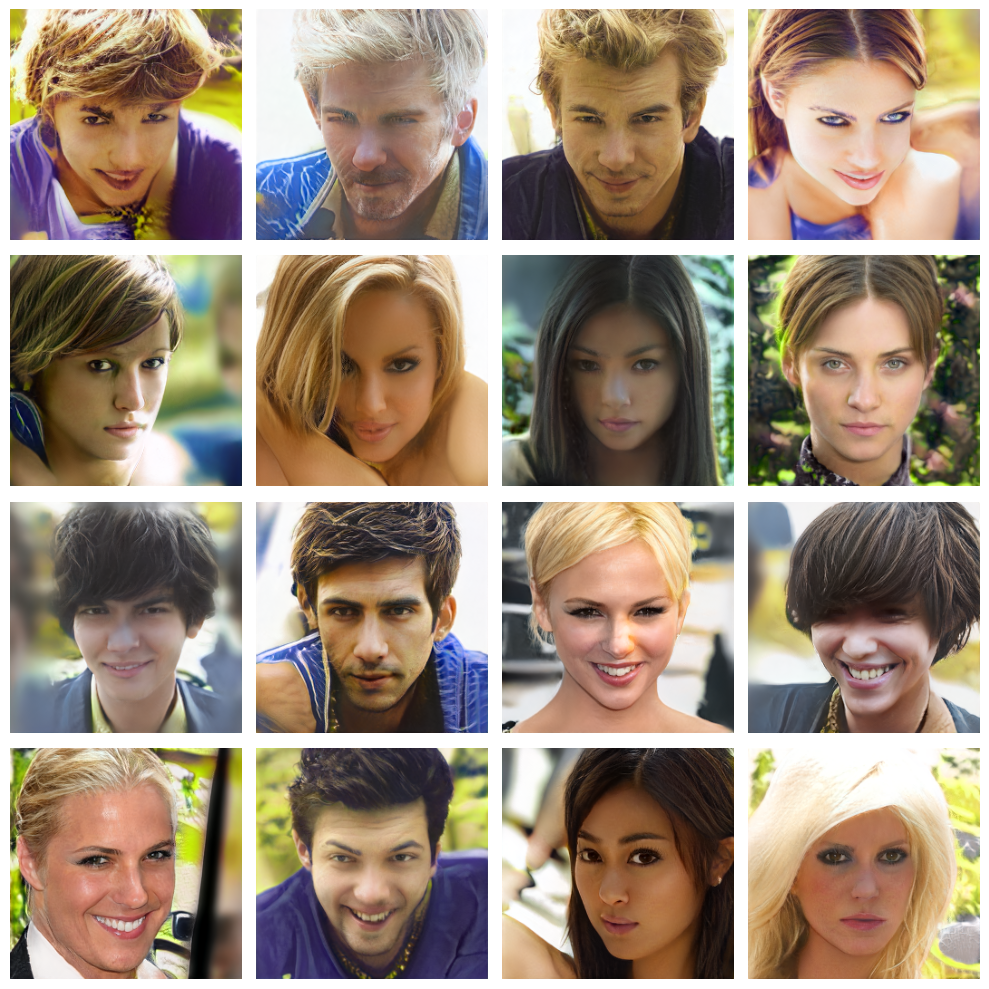

In [229]:
latents = get_top_latents(SAE, test_data, idx, k = 16, largest = True)
images = sample(G, latents)
display_img(images, h = 4, w = 4)

100%|██████████| 1000/1000 [00:05<00:00, 193.17it/s]


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='mps:0')


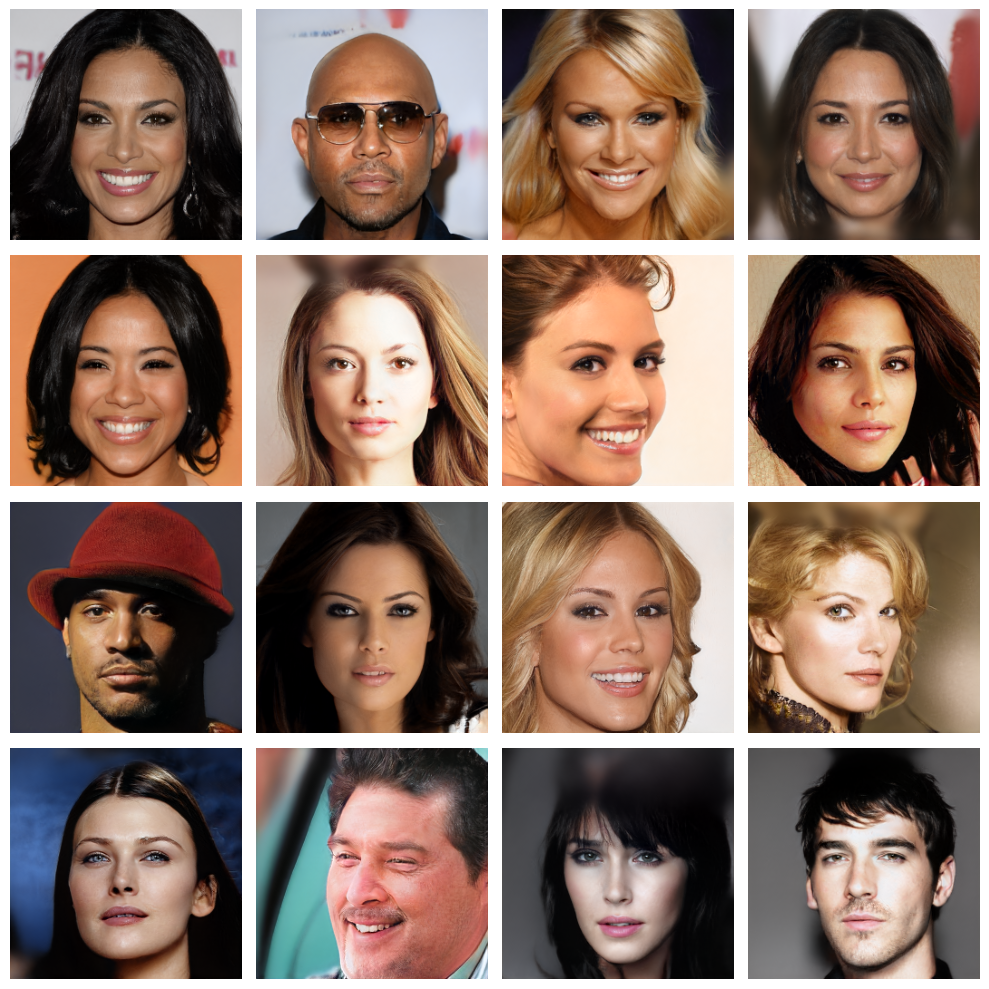

In [230]:
latents = get_top_latents(SAE, test_data, idx, k = 16, largest = False)
images = sample(G, latents)
display_img(images, h = 4, w = 4)